# load data

In [2]:
import numpy as np
import pandas as pd
!cp /content/drive/MyDrive/muscle_promoter/utils.py .
from utils import *

In [5]:
!wget https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz
!wget https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt
!gzip -d *gz

In [6]:
all_data = pd.read_csv('GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct', skiprows=2, sep='\t' )
attr = pd.read_csv("GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t')

In [7]:
all_data.index = all_data.Name
all_data.drop(columns=['Name','Description'], inplace=True)

In [8]:
index = np.load('/content/drive/MyDrive/muscle_promoter/training_data/selected_index.npy', allow_pickle=True)
all_data = all_data.loc[index]
all_data.shape

(23075, 17382)

In [9]:
all_data = all_data.div(all_data.sum(axis=0), axis=1)*1000000 #count per million

In [10]:
attr = pd.read_csv("GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t')
attr_blood = attr[attr.SMTSD=='Whole Blood']['SAMPID'].tolist()
attr_heart = attr[attr.SMTSD=='Heart - Left Ventricle']['SAMPID'].tolist()

attr_blood = intersection(all_data.columns.tolist(), attr_blood)
attr_heart = intersection(all_data.columns.tolist(), attr_heart)

len(attr_blood), len(attr_heart)

(755, 432)

In [11]:
blood_testset = pd.read_csv('/content/drive/MyDrive/muscle_promoter/training_data/cpm_blood_testset.txt', sep='\t', index_col=0)
heart_testset = pd.read_csv('/content/drive/MyDrive/muscle_promoter/training_data/cpm_heart_testset.txt', sep='\t', index_col=0)

In [16]:
blood_selected_for_training = [i for i in attr_blood if i not in blood_testset.columns.tolist()]
heart_selected_for_training = [i for i in attr_heart if i not in heart_testset.columns.tolist()]

len(blood_selected_for_training), len(heart_selected_for_training)

(680, 357)

In [18]:
blood_selected_for_training = all_data[blood_selected_for_training]
heart_selected_for_training = all_data[heart_selected_for_training]

In [19]:
blood_selected_for_training = np.array(blood_selected_for_training.T)
heart_selected_for_training = np.array(heart_selected_for_training.T)

In [20]:
X_train = np.load('/content/drive/MyDrive/muscle_promoter/training_data/X_train.npy', allow_pickle=True)

X_train, blood_selected_for_training_normalized, heart_selected_for_training_normalized = normalize_data(X_train, blood_selected_for_training, heart_selected_for_training)

# finetuning blood sample

In [49]:
np.random.shuffle(blood_selected_for_training_normalized)
blood_selected_for_training_normalized

array([[ 1.48917529,  2.73606025,  2.20646512, ..., -0.86185058,
        -0.31580574, -1.10179816],
       [-0.68977679,  6.45348267,  6.84473044, ..., -0.88761171,
        -0.30099399, -1.22097942],
       [ 0.56969213,  5.87741105,  4.47183777, ..., -0.94639303,
        -0.34768632, -1.16332162],
       ...,
       [ 0.03659023,  2.36431565,  2.49452634, ..., -0.89569187,
        -0.34768632, -1.11758038],
       [-0.2643469 ,  2.51562623,  1.71572926, ..., -0.8572022 ,
        -0.2848824 , -1.16394137],
       [ 0.54441805,  1.8637869 ,  1.47608469, ..., -0.83530522,
        -0.34768632, -1.08019613]])

In [54]:
autoencoder64 = keras.models.load_model('/content/drive/MyDrive/muscle_promoter/GTEx8_autoencoder2_512-128-64_initHe_lr0.001.h5')
optimizer = tf.optimizers.Adam(learning_rate=0.0001)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, mode='min')
checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/muscle_promoter/GTEx8_blood_autoencoder64.h5', 
                                               monitor='val_loss', mode='min',
                                               verbose=1, save_best_only=True) 

history=autoencoder64.fit(blood_selected_for_training_normalized, blood_selected_for_training_normalized, 
                        validation_split=0.25,
                        epochs=1000000, batch_size=10000, 
                        callbacks=[early_stop, checkpoint]
                        )

Epoch 1/1000000
1/1 [==============================] - ETA: 0s - loss: 2.3077
Epoch 1: val_loss improved from inf to 1.56201, saving model to /content/drive/MyDrive/muscle_promoter/GTEx8_blood_autoencoder64.h5
1/1 [==============================] - 2s 2s/step - loss: 2.3077 - val_loss: 1.5620
Epoch 2/1000000
1/1 [==============================] - ETA: 0s - loss: 1.3871
Epoch 2: val_loss did not improve from 1.56201
1/1 [==============================] - 0s 75ms/step - loss: 1.3871 - val_loss: 8.4979
Epoch 3/1000000
1/1 [==============================] - ETA: 0s - loss: 1.0326
Epoch 3: val_loss did not improve from 1.56201
1/1 [==============================] - 0s 73ms/step - loss: 1.0326 - val_loss: 9.2168
Epoch 4/1000000
1/1 [==============================] - ETA: 0s - loss: 0.7254
Epoch 4: val_loss did not improve from 1.56201
1/1 [==============================] - 0s 84ms/step - loss: 0.7254 - val_loss: 6.5215
Epoch 5/1000000
1/1 [==============================] - ETA: 0s - loss: 0.

In [55]:
from sklearn.metrics import mean_squared_error

blood_pred = autoencoder64.predict(blood_selected_for_training_normalized)
mean_squared_error(blood_selected_for_training_normalized, blood_pred)

0.13592305048981868

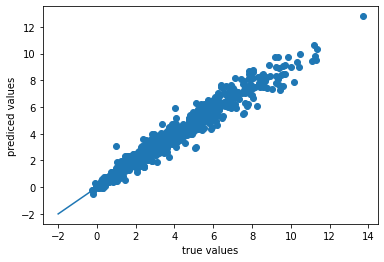

In [53]:
import matplotlib.pyplot as plt

i=3000
plt.scatter(blood_selected_for_training_normalized.T[i], blood_pred.T[i])
plt.xlabel('true values')
plt.ylabel('prediced values')
plt.plot([-2,5],[-2,5])
plt.show()

# finetuning heart sample

In [38]:
np.random.shuffle(heart_selected_for_training_normalized)
heart_selected_for_training_normalized

array([[-1.11350594, -0.28062386, -0.2969191 , ...,  1.98619962,
         0.53266621,  0.30415105],
       [-1.34009565, -0.26738135, -0.25710205, ...,  0.13576319,
        -0.2090343 ,  1.72083533],
       [-1.0066004 , -0.26277831, -0.28199237, ...,  2.92647152,
         3.1873545 ,  2.58126519],
       ...,
       [-1.04247932, -0.30083602, -0.31601902, ...,  4.35757021,
         0.8580912 ,  1.78005709],
       [-1.15305065, -0.28403137, -0.27255715, ...,  1.02345637,
         0.12994516,  1.62803854],
       [-0.48319355, -0.24381307, -0.22271978, ...,  0.11051065,
        -0.15119468,  1.43913042]])

In [40]:
autoencoder32 = keras.models.load_model('/content/drive/MyDrive/muscle_promoter/GTEx8_autoencoder2_512-128-32_initHe_lr0.001.h5')
optimizer = tf.optimizers.Adam(learning_rate=0.0001)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, mode='min')
checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/muscle_promoter/GTEx8_heart_autoencoder32.h5', 
                                               monitor='val_loss', mode='min',
                                               verbose=1, save_best_only=True) 

history=autoencoder32.fit(heart_selected_for_training_normalized, heart_selected_for_training_normalized, 
                        validation_split=0.25,
                        epochs=1000000, batch_size=10000, 
                        callbacks=[early_stop, checkpoint]
                        )

Epoch 1/1000000
1/1 [==============================] - ETA: 0s - loss: 1.5573
Epoch 1: val_loss improved from inf to 0.56968, saving model to /content/drive/MyDrive/muscle_promoter/GTEx8_heart_autoencoder32.h5
1/1 [==============================] - 1s 1s/step - loss: 1.5573 - val_loss: 0.5697
Epoch 2/1000000
1/1 [==============================] - ETA: 0s - loss: 0.8861
Epoch 2: val_loss did not improve from 0.56968
1/1 [==============================] - 0s 64ms/step - loss: 0.8861 - val_loss: 2.5342
Epoch 3/1000000
1/1 [==============================] - ETA: 0s - loss: 0.6247
Epoch 3: val_loss did not improve from 0.56968
1/1 [==============================] - 0s 58ms/step - loss: 0.6247 - val_loss: 3.0234
Epoch 4/1000000
1/1 [==============================] - ETA: 0s - loss: 0.4640
Epoch 4: val_loss did not improve from 0.56968
1/1 [==============================] - 0s 60ms/step - loss: 0.4640 - val_loss: 2.2633
Epoch 5/1000000
1/1 [==============================] - ETA: 0s - loss: 0.

In [ ]:
autoencoder16 = keras.models.load_model('/content/drive/MyDrive/muscle_promoter/GTEx8_autoencoder2_512-128-16_initHe_lr0.001.h5')
optimizer = tf.optimizers.Adam(learning_rate=0.0001)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, mode='min')
checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/muscle_promoter/GTEx8_heart_autoencoder16.h5', 
                                               monitor='val_loss', mode='min',
                                               verbose=1, save_best_only=True) 

history=autoencoder16.fit(heart_selected_for_training_normalized, heart_selected_for_training_normalized, 
                        validation_split=0.25,
                        epochs=1000000, batch_size=10000, 
                        callbacks=[early_stop, checkpoint]
                        )

In [67]:
heart_pred = autoencoder16.predict(heart_selected_for_training_normalized)

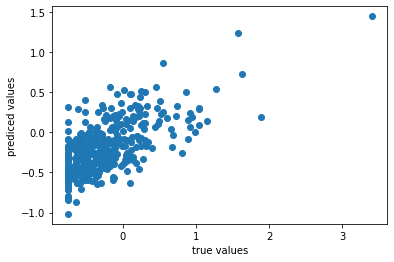

In [72]:
import matplotlib.pyplot as plt

i=6008
plt.scatter(heart_selected_for_training_normalized.T[i], heart_pred.T[i])
plt.xlabel('true values')
plt.ylabel('prediced values')
#plt.plot([-2,5],[-2,5])
plt.show()